In [93]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

df = pd.read_csv("/Users/Yur/Downloads/ovitrap_data_with_province.csv", index_col=[0], usecols = ['date', 'id', 'value', 'adm'])

## Get a summary of the data per school, this makes the datacleaning more easy
    - Get schools with more than 40 observations, to have more reliable measurements
    - Filter schools with a maximum level that is less than 10 (very unlikely, probably misreporting)
    - Filter school with very high means (result of misreporting)
    - Filter schools with more than 75% 100's or 0's
    - Filter schools with only the same observations
    - Remove values that are between (0, 1.5], [98.5, 100)  as it is not plausible that a school has more than 60 ovitraps
    

In [94]:
summary_df = df.groupby(['id']).describe()

In [95]:
summary_df.columns = summary_df.columns.droplevel(0)

In [96]:
n = len(df)
sum_df = summary_df[summary_df['count'] > 40]
print('Lost values more than n values per school: ', n-len(df[df['id'].isin(sum_df.index.tolist())]))
n = len(df[df['id'].isin(sum_df.index.tolist())])

sum_df = sum_df[sum_df['max'] > 10] 
print('Lost values for schools that have a maximum less than 10: ', n-len(df[df['id'].isin(sum_df.index.tolist())]))
n = len(df[df['id'].isin(sum_df.index.tolist())])

sum_df = sum_df[sum_df['mean'] < 90]
print('Lost values for schools with a mean higher than 90: ', n-len(df[df['id'].isin(sum_df.index.tolist())]))
n = len(df[df['id'].isin(sum_df.index.tolist())])

zeros_df = sum_df[~((sum_df['75%']==0) & (sum_df['max']==100))]
print('75% zeros and a max of 100: ', n-len(df[df['id'].isin(zeros_df.index.tolist())]))
n = len(df[df['id'].isin(zeros_df.index.tolist())])

zeros_df = zeros_df[~(zeros_df['75%']==zeros_df['max'])]
print('75% of values is equal to max: ', n-len(df[df['id'].isin(zeros_df.index.tolist())]))
n = len(df[df['id'].isin(zeros_df.index.tolist())])

zeros_df = zeros_df[~((zeros_df['mean']<2)&(zeros_df['max']>50))]
print('Mean lower than 2 and max higher than 50: ', n-len(df[df['id'].isin(zeros_df.index.tolist())]))
n = len(df[df['id'].isin(zeros_df.index.tolist())])

# get df back from school level to observation level
clean_school_df = (df[df['id'].isin(zeros_df.index.tolist())]) 

clean_df = clean_school_df[~((clean_school_df['value']>0) & (clean_school_df['value']<1.5))] # removes values 0<x<1.5
print('Amount of values that are between 0 < x < 1.5: ', n-len(clean_df))
n=len(clean_df)

clean_df = clean_df[~((clean_df['value']<100) & (clean_df['value']>98.5))] # removes values 98.5<x<100
print('Amount of vaues between 98.5 < x < 100: ', n-len(clean_df))

print('Total amount of values, before last data cleaning part: ', len(clean_df))

Lost values more than n values per school:  94464
Lost values for schools that have a maximum less than 10:  1727
Lost values for schools with a mean higher than 90:  241
75% zeros and a max of 100:  259
75% of values is equal to max:  887
Mean lower than 2 and max higher than 50:  69
Amount of values that are between 0 < x < 1.5:  198
Amount of vaues between 98.5 < x < 100:  6
Total amount of values, before last data cleaning part:  39205


In [97]:
# Export DataFrame to csv file
export_csv = clean_df.to_csv('OviTrapData.csv') 

## Create column that reports if a value occurs more than n (n=7) times in a row

In [98]:
# Import filtered dataset
df = pd.read_csv('OviTrapData.csv', parse_dates=['date'], usecols=['date', 'id', 'value', 'adm'])

In [101]:
# adds the number of times a recurrent values occurs given that it occurs more than 5 times in a row
i=0
sequence = np.zeros(len(df))
df = df[['date', 'id', 'value', 'adm']]
while i < len(df)-1:
    j = 1
    value = df.iloc[i, 2]
    value_id = df.iloc[i,1]
    next_value = df.iloc[i+j, 2]
    next_value_id = df.iloc[i+j, 1]
    
    while (next_value == value) and (next_value_id == value_id):
        next_value = df.iloc[i+j, 2]
        next_value_id = df.iloc[i+j, 1]
        j = j + 1
    
    if j > 6:
        sequence[i:(i+j-1)] = (j-1)
        i = i + j - 1
    else:
        i = i + 1
        
df['Recurring value'] = sequence

### Removes values that occur more than 7 times at the start or end of a school's observations

In [77]:
# adds 1 if recurring values occur at the start of end of a schools observations

current_school  = df['id'][0]
first_last   = np.zeros(len(df))

for i in range(len(df)):
    new_school = df['id'][i]
    if (current_school != new_school):
        amount_last = int(df['Recurring value'][i-1])
        amount_first = int(df['Recurring value'][i])
        if amount_last > 0:
            first_last[(i-amount_last):(i)] = 1     
        if amount_first > 0:
            first_last[i:(i+amount_first)] = 1

    current_school = new_school

amount = int(df['Recurring value'][len(df)-1])
if amount > 0:
    first_last[-amount:] = 1
df['first_last'] = first_last

# get rid of recurring values at the start or end of school
check_df_id = df[((df['Recurring value']>0) & (df['first_last']>0))]
df = df[~((df['Recurring value']>0) & (df['first_last']>0))]
df = df.drop(columns = ['Recurring value', 'first_last'])

36933


### Create the final dataset

In [78]:
df['date'] = pd.to_datetime(df['date'])
df['week'] = df['date'].dt.week
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

In [79]:
monthly_data = pd.DataFrame(df.groupby(['year', 'month', 'adm'])['value'].mean()).reset_index().sort_values(by=['adm', 'year'])
monthly_data['day'] = np.ones(len(monthly_data))
monthly_data['date'] = pd.to_datetime(monthly_data[['year', 'month', 'day']])
monthly_data = monthly_data.drop(columns=['year', 'month','day'])
month_fill = monthly_data.groupby(['adm', 'date']).sum()

## Create missing value plot

In [80]:
df_original = pd.read_csv("/Users/Yur/Downloads/ovitrap_data_with_province.csv", index_col=[0], usecols = ['date', 'id', 'value', 'adm'])

In [81]:
adm_levels = df_og.adm.unique()
months = pd.date_range(start='2012-05', end='2019-09', freq='MS') 
df_final = pd.DataFrame(index=pd.MultiIndex.from_product([adm_levels, months],
                                                         names=['adm', 'date']))
df_final['value'] = 0.

value
adm                  date             
NCR, Fourth District 2012-05-01    0.0
                     2012-06-01    0.0
                     2012-07-01    0.0
                     2012-08-01    0.0
                     2012-09-01    0.0

In [82]:
df_plot = df_final.add(month_fill, fill_value=-1).reset_index()

In [83]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

#Visualize missing values - code was found on the Internet
def missing_values_graph(frame, obs, date, var, Yname):
    df = frame[[obs, date, var]]
    df[var].fillna(-1, inplace=True)
    df = df.groupby([obs, date])[var].aggregate('mean').unstack()
    df.columns = df.columns.strftime('%Y-%m')
    df[df > 0] = 1
    cmap = sns.xkcd_palette(["light grey", "medium grey"])
    plt.figure(figsize=(18, 5))
    ax = sns.heatmap(df, center=0, cmap=cmap, cbar=False,
                     cbar_kws={'ticks': [-1, 0, 1]})
    ax.set(yticklabels=[])
    ax.set_xticklabels(df, fontsize='large', rotation=70)
    plt.ylabel(Yname+ " (N=" + str(len(df)) + ")", fontsize=14)
    plt.tight_layout()

    plt.show()

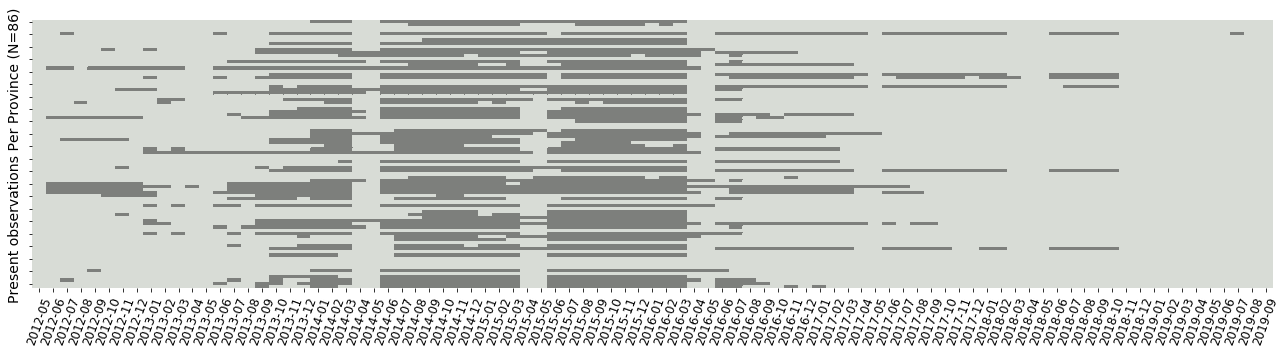

In [84]:
missing_values_graph(df_plot, "adm", "date", "value", "Present observations Per Province")

In [85]:
adm_levels = df.adm.unique()
months = pd.date_range(start='1/1/2013', end='1/12/2016', freq='MS') 
df_final = pd.DataFrame(index=pd.MultiIndex.from_product([adm_levels, months],
                                                         names=['adm', 'date']))
df_final['value'] = 0.
df_final.head()

value
adm                  date             
NCR, Fourth District 2013-01-01    0.0
                     2013-02-01    0.0
                     2013-03-01    0.0
                     2013-04-01    0.0
                     2013-05-01    0.0

In [86]:
aggregated_month = df_final.add(month_fill, fill_value=0).reset_index()

In [90]:
# dataset without filled months, that are not in the dates of a specific province's observations
export_csv = month_fill.to_csv('monthly_mosquito_per_province.csv') 

In [92]:
# dataset with filled months, that are not in the dates of a specific province's observations
export_csv = aggregated_month.to_csv('aggregated_monthly.csv') 

In [88]:
# Print number of schools in each province in the dataset
provinces = df.adm.unique().tolist()
#make a dictionary, place means in this dictionary
for province in provinces:
    df_province = df[df['adm']==province]
    n_schools = len(df_province['id'].unique().tolist())
    np.zeros(n_schools)
    for school in df_province['id'].unique().tolist():
        df_school = df_province[df_province['id']==school]
    print(province, ' #schools = ', n_schools)

NCR, Fourth District  #schools =  43
NCR, City of Manila, First District  #schools =  13
NCR, Second District  #schools =  26
NCR, Third District  #schools =  38
Bulacan  #schools =  30
Albay  #schools =  20
Aurora  #schools =  5
Leyte  #schools =  10
Compostela Valley  #schools =  11
Negros Occidental  #schools =  1
Davao del Sur  #schools =  12
Camarines Sur  #schools =  8
Iloilo  #schools =  5
Marinduque  #schools =  11
Zamboanga Sibugay  #schools =  6
Occidental Mindoro  #schools =  2
Zamboanga del Sur  #schools =  10
Cavite  #schools =  16
Oriental Mindoro  #schools =  6
Romblon  #schools =  4
Nueva Ecija  #schools =  19
Masbate  #schools =  9
Sorsogon  #schools =  8
Cebu  #schools =  11
Bataan  #schools =  11
Tarlac  #schools =  9
Batangas  #schools =  33
Zambales  #schools =  6
Pampanga  #schools =  11
Bukidnon  #schools =  5
Zamboanga del Norte  #schools =  12
Quezon  #schools =  31
Negros Oriental  #schools =  5
Siquijor  #schools =  2
Laguna  #schools =  27
Isabela  #schools 